<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/notes_pytorch/ImgRec/Xception_cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Xception

元論文 >> Xception: Deep Learning with Depthwise Separable Convolutions https://arxiv.org/abs/1610.02357


GoogLeNetで使われているInceptionはどのように効果的なのかに重きを置いて作られたのがXception。

Separable Conov は Depthwise conv と Pointwise conv の組み合わせになる。

<img src="images/separable_conv.png" width=800>

Xceptionでは最初の2つのconv意外は全部Separable convになる。


In [1]:
!pip install -q --upgrade albumentations==0.5.1

The directory '/Users/yoshitonagaoka/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/yoshitonagaoka/Library/Caches/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/Users/yoshitonagaoka/dev/miniconda3/lib/python3.7/site-packages/shapely'
Consider using the `--user` option or check the permissions.



# torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

def get_model(out_dim, dropout=0.5, pretrained=True):
    #---
    # not implemented
    #---

    return None

# scratch

## Xception

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1)

class SeparableConv(nn.Module):
    def __init__(self, dim_in=, dim_out):
        super(SeparableConv, self).__init__()

        self.module = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size=3, padding=1, stride=1, groups=dim_in),
            nn.Conv2d(dim_in, dim_out, kernel_size=1, padding=0, stride=1),
        )
        
    def forward(self, x):
        return self.module(x)


class XceptionBlock(nn.Module):
    def __init__(self, dim=728, cardinality=728):
        super(XceptionBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReLU(),
            nn.SeparableConv(dim, dim),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.SeparableConv(dim, dim),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.SeparableConv(dim, dim),
            nn.BatchNorm2d(dim),
        )
        
    def forward(self, x):
        res_x = self.block(x)            
        x = res_x + x
        return x
        

class Xception(nn.Module):
    def __init__(self, out_dim, in_height=32, in_width=32):
        super(Xception, self).__init__()

        self.in_height = in_height
        self.in_width = in_width

        
        # Entry flow
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
            nn.SeparableConv(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.SeparableConv(128, 128),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        self.conv3_skip = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, padding=0, stride=2),
            nn.BatchNorm2d(128)
        )
        
        self.conv4 = nn.Sequential(
            nn.ReLU(),
            nn.SeparableConv(128, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.SeparableConv(256, 256),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        self.conv4_skip = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, padding=0, stride=2),
            nn.BatchNorm2d(256)
        )
        
        self.conv5 = nn.Sequential(
            nn.ReLU(),
            nn.SeparableConv(256, 728),
            nn.BatchNorm2d(728),
            nn.ReLU(),
            nn.SeparableConv(728, 728),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        self.conv5_skip = nn.Sequential(
            nn.Conv2d(256, 728, kernel_size=1, padding=0, stride=2),
            nn.BatchNorm2d(728)
        )
        
        # Middle flow
        self.middle_flow = nn.Sequential(
            *[XceptionBlock() for _ in range(8)]
        )
        
        # Exit flow
        self.conv_exit1 = nn.Sequential(
            nn.ReLU(),
            nn.SeparableConv(728, 728),
            nn.BatchNorm2d(728),
            nn.ReLU(),
            nn.SeparableConv(728, 1024),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        self.conv_exit1_skip = nn.Sequential(
            nn.Conv2d(728, 1024, kernel_size=1, padding=0, stride=2),
            nn.BatchNorm2d(1024)
        )
        
        self.conv_exit2 = nn.Sequential(
            nn.SeparableConv(1024, 1536),
            nn.BatchNorm2d(1536),
            nn.ReLU(),
            nn.SeparableConv(1536, 2048),
            nn.BatchNorm2d(2048)
        )
        
        self.top= nn.Linear(2048, out_dim)
        
        
    def forward(self, x):
        # Entry flow
        x = self.conv1(x)
        x = self.conv2(x)
        
        x_skip = self.conv3_skip(x)
        x = self.conv3(x)
        x = x + x_skip

        x_skip = self.conv4_skip(x)
        x = self.conv4(x)
        x = x + x_skip
        
        x_skip = self.conv5_skip(x)
        x = self.conv5(x)
        x = x + x_skip
        
        # Middle flow
        x = self.middle_flow(x)
        
        # Exit flow
        x_skip = self.conv_exit1_skip(x)
        x = self.conv_exit1(x)
        x = x + x_skip
        
        x = self.conv_exit2(x)

        x = F.avg_pool2d(x, [self.in_height // 32, self.in_width // 32], padding=0, stride=1)
        x = x.view(x.size()[0], -1)
        x = self.top(x)
        
        return x

# Import

In [4]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
import albumentations.pytorch as Ap

import torchvision
import torchvision.models as models

In [5]:
IN_HEIGHT, IN_WIDTH = 32, 32

RESOURCE = "GPU"

FOLD = "StratifiedKFold" # KFold, GroupKFold, StratifiedKFold, StratifiedGroupXX
FOLD_N = 2 # fold num

RANDOM_SEED = 42

if RESOURCE == "CPU":
    device = torch.device("cpu")
elif RESOURCE == "GPU":
    device = torch.device("cuda")

# prepare data

In [6]:
train_ds = torchvision.datasets.CIFAR10(root="./", train=True, download=True, transform=None)
train_Xs = train_ds.data
train_ys = np.array(train_ds.targets)

class CifarDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms=transforms
        self.data_num = len(xs)
        
    def __len__(self):
        return self.data_num
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            transformed = self.transforms(image=x)
            x = transformed["image"]
            
        return x, y

Extracting ./cifar-10-python.tar.gz to ./


In [7]:
transforms_train = A.Compose([
    A.RandomResizedCrop(IN_HEIGHT, IN_WIDTH, scale = (0.9,1.0),ratio = (0.9,1.1),p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.1,val_shift_limit=0.1,p=0.2),
    A.RandomBrightnessContrast(brightness_limit = (-0.2,0.2), contrast_limit = (-0.1,0.1), p=0.2),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Ap.ToTensorV2(p=1.0),
])

transforms_val = A.Compose([
    A.Resize(IN_HEIGHT, IN_WIDTH),
    A.Normalize(max_pixel_value=255.0, p=1.0),
    Ap.ToTensorV2(p=1.0),
])

# Train

In [8]:
def train():
    # fold
    if FOLD == "KFold":
        kf = KFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds)
        
    elif FOLD == "GroupKFold":
        kf = GroupKFold(n_splits=FOLD_N)
        spl = kf.split(train_ds.data, train_ds.targets, train_ds.targets)
        
    elif FOLD == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=FOLD_N, shuffle=True, random_state=RANDOM_SEED)
        spl = kf.split(train_ds.data, train_ds.targets)

    else:
        print("invalid fold")
        return None
    
    train_models = []
    train_model_paths = []

    val_cv_loss = []
    val_cv_accuracy = []
    
    val_cv_labels = []
    val_cv_preds = []

    EPOCH = 30
    
    for fold_i, (train_idx, val_idx) in enumerate(spl):
        
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        
        print(f"{FOLD} fold:{fold_i + 1}/{FOLD_N}")
        print(f"train_N={len(train_idx)}, val_N={len(val_idx)}")
            
        #---
        # datasert
        #---
        X_train = train_Xs[train_idx]
        y_train = train_ys[train_idx]
        X_val = train_Xs[val_idx]
        y_val = train_ys[val_idx]

        dataset_train = CifarDataset(X_train, y_train, transforms=transforms_train)
        dataset_val = CifarDataset(X_val, y_val, transforms=transforms_val)

        dataloader_train = DataLoader(dataset_train, batch_size=256, num_workers=4, shuffle=True, pin_memory=True)
        dataloader_val = DataLoader(dataset_val, batch_size=256, num_workers=4, shuffle=False, pin_memory=True)
        
        train_n = len(X_train)
        val_n = len(X_val)
        target_n = 1
        
        #---
        # model
        #---
        # model = get_model(out_dim=10, pretrained=True, dropout=0.5)
        model = Xception(out_dim=10)
        model = model.to(device)
        
        criterion = nn.CrossEntropyLoss(reduction="sum")
        # criterion = nn.BCELoss(reduction="sum")
        # optimizer = optim.SGD(model.parameters(), lr=0.01)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50], gamma=0.1, last_epoch=-1)
    
        #---
        # epoch
        #---
        for epoch in range(EPOCH):

            model.train()
            
            tr_loss = 0
            correct = 0
            total = 0
            
            #---
            # train
            #---
            train_time_start = time.time()
            
            for step, batch in enumerate(dataloader_train):
                optimizer.zero_grad()

                xs = batch[0].to(device) # image
                ys = batch[1].to(device) # target
            
                outputs = model(xs)
             
                loss = criterion(outputs, ys)
                        
                loss = loss / train_n
                loss.backward()

                loss = loss.item()
                tr_loss += loss
                
                _, predicted = torch.max(outputs.data, 1)
                total += ys.size(0)
                correct += (predicted == ys).sum().item()

                optimizer.step()

            train_losses.append(tr_loss)
            
            train_accuracy = correct / total
            train_accuracies.append(train_accuracy)

            train_time_end = time.time()

            #---
            # val
            #---
            model.eval()

            val_loss = 0
            val_correct = 0
            val_total = 0
            
            val_time_start = time.time()
            
            val_labels = []
            val_preds = []
            
            with torch.no_grad():
                for step, batch in enumerate(dataloader_val):
                    xs = batch[0].to(device) # image
                    ys = batch[1].to(device) # target
                    
                    outputs = model(xs)

                    loss = criterion(outputs, ys)
                        
                    val_loss += loss.item() / val_n
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += ys.size(0)
                    val_correct += (predicted == ys).sum().item()
                    
                    val_labels.extend(ys.detach().cpu().numpy().tolist())
                    val_preds.extend(predicted.detach().cpu().numpy().tolist())

            val_time_end = time.time()
            train_time_total = train_time_end - train_time_start
            val_time_total = val_time_end - val_time_start
            total_time = train_time_total + val_time_total
                
            val_losses.append(val_loss)
            
            val_accuracy = val_correct / val_total
            val_accuracies.append(val_accuracy)

            print(f"fold:{fold_i + 1} epoch:{epoch + 1}/{EPOCH} [tra]loss:{tr_loss:.4f} acc:{train_accuracy:.4f}  [val]loss:{val_loss:.4f} acc:{val_accuracy:.4f}  [time]total:{total_time:.2f}sec tra:{train_time_total:.2f}sec val:{val_time_total:.2f}sec")

#             lr_scheduler.step()


            if (epoch + 1) % 100 == 0:
                savename = f"model_epoch{epoch + 1}_{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
                torch.save(model.state_dict(), savename)
                print(f"model saved to >> {savename}")

        #---
        # store last val loss and accuracy
        #---
        val_cv_loss.append(val_loss)
        val_cv_accuracy.append(val_accuracy)
        
        val_cv_labels.extend(val_labels)
        val_cv_preds.extend(val_preds)
           
        #---
        # save model
        #---
        savename = f"model_epoch{EPOCH}_{FOLD}_{fold_i + 1}_{FOLD_N}.pth"
        torch.save(model.state_dict(), savename)
        print(f"model saved to >> {savename}")
        print()
        
        train_models.append(model)
        train_model_paths.append(savename)
        

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker=".", markersize=6, color="green", label="train accuracy")
        ax2.plot(val_accuracies, marker=".", markersize=6, color="orange", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        
    
    #---
    # display fold score
    #---
    val_cv_loss = np.array(val_cv_loss)
    val_cv_accuracy = np.array(val_cv_accuracy)
    
    print("all folds score")
    print(f"total loss:{val_cv_loss.mean():.6f}, accuracy:{val_cv_accuracy.mean():.6f}")
    for i in range(FOLD_N):
        print(f"fold{i + 1}/{FOLD_N} loss:{val_cv_loss[i]:.6f}, accuracy:{val_cv_accuracy[i]:.6f}")
        
    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":val_cv_labels, "pred":val_cv_preds})
    print()
    print("cross table")
    display(pd.crosstab(res_df["label"], res_df["pred"]))
        
    return train_models, train_model_paths

StratifiedKFold fold:1/2
train_N=25000, val_N=25000
fold:1 epoch:1/30 [tra]loss:2.2920 acc:0.1816  [val]loss:1.9440 acc:0.2738  [time]total:63.90sec tra:48.75sec val:15.15sec
fold:1 epoch:2/30 [tra]loss:1.9565 acc:0.2726  [val]loss:2.6163 acc:0.2998  [time]total:66.21sec tra:50.38sec val:15.83sec
fold:1 epoch:3/30 [tra]loss:1.9069 acc:0.2973  [val]loss:3.6302 acc:0.2843  [time]total:67.81sec tra:51.65sec val:16.16sec
fold:1 epoch:4/30 [tra]loss:2.0072 acc:0.2810  [val]loss:2.5709 acc:0.2408  [time]total:68.46sec tra:52.24sec val:16.22sec
fold:1 epoch:5/30 [tra]loss:1.9060 acc:0.3059  [val]loss:2.0079 acc:0.3185  [time]total:68.67sec tra:52.52sec val:16.15sec
fold:1 epoch:6/30 [tra]loss:1.7953 acc:0.3467  [val]loss:2.1128 acc:0.3675  [time]total:69.00sec tra:52.66sec val:16.34sec
fold:1 epoch:7/30 [tra]loss:1.7848 acc:0.3611  [val]loss:1.9235 acc:0.3761  [time]total:69.21sec tra:52.91sec val:16.30sec
fold:1 epoch:8/30 [tra]loss:1.7281 acc:0.3779  [val]loss:1.6671 acc:0.4056  [time]total

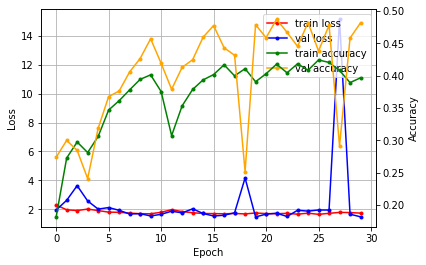

StratifiedKFold fold:2/2
train_N=25000, val_N=25000
fold:2 epoch:1/30 [tra]loss:2.3500 acc:0.1906  [val]loss:2.4556 acc:0.2231  [time]total:69.21sec tra:52.86sec val:16.35sec
fold:2 epoch:2/30 [tra]loss:2.0561 acc:0.2434  [val]loss:2.9672 acc:0.2706  [time]total:69.32sec tra:52.89sec val:16.42sec
fold:2 epoch:3/30 [tra]loss:1.9012 acc:0.3027  [val]loss:1.9152 acc:0.3448  [time]total:69.40sec tra:52.98sec val:16.42sec
fold:2 epoch:4/30 [tra]loss:1.8785 acc:0.3278  [val]loss:1.9724 acc:0.3744  [time]total:69.34sec tra:52.96sec val:16.39sec
fold:2 epoch:5/30 [tra]loss:1.8143 acc:0.3448  [val]loss:1.8012 acc:0.3320  [time]total:69.48sec tra:53.11sec val:16.37sec
fold:2 epoch:6/30 [tra]loss:1.7553 acc:0.3690  [val]loss:1.6163 acc:0.4233  [time]total:69.56sec tra:53.06sec val:16.50sec
fold:2 epoch:7/30 [tra]loss:1.7861 acc:0.3642  [val]loss:1.8079 acc:0.3679  [time]total:69.71sec tra:53.19sec val:16.52sec
fold:2 epoch:8/30 [tra]loss:1.7791 acc:0.3675  [val]loss:1.5123 acc:0.4495  [time]total

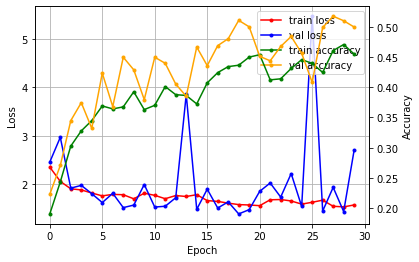

all folds score
total loss:2.088131, accuracy:0.490460
fold1/2 loss:1.472358, accuracy:0.481480
fold2/2 loss:2.703903, accuracy:0.499440

cross table


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,2229,353,390,67,389,96,74,97,1078,227
1,197,3682,64,32,10,42,91,83,204,595
2,432,229,1770,222,778,326,568,421,191,63
3,150,212,448,1362,214,926,930,392,218,148
4,190,50,601,179,1971,139,830,797,158,85
5,108,154,394,924,258,1891,432,539,197,103
6,61,163,322,192,299,91,3612,167,38,55
7,122,214,264,230,446,362,256,2843,114,149
8,704,460,81,74,124,68,78,36,3077,298


In [9]:
train_models, train_model_paths = train()

# Test

In [10]:
# test
def test(train_models):
    for model in train_models:
        model.eval()

    model_num = len(train_models)

    test_ds = torchvision.datasets.CIFAR10(root="./", train=False, download=True, transform=None)
    test_Xs = test_ds.data
    test_ys = np.array(test_ds.targets)

    dataset_test = CifarDataset(test_Xs, test_ys, transforms=transforms_val)
    dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4, shuffle=False, pin_memory=True)

    preds = []
    correct = 0

    with torch.no_grad():
         for step, batch in enumerate(dataloader_test):
            Xs = batch[0].to(device) # image
            ys = batch[1]

            _preds = np.zeros([len(ys), 10])

            for model in train_models:
                model_preds = F.softmax(model(Xs), dim=1).detach().cpu().numpy()
                _preds += model_preds / model_num

            _preds = _preds.argmax(axis=1)

            preds.extend(_preds)

            correct += sum(ys.numpy() == _preds)

    #---
    # label x pred
    #---
    res_df = pd.DataFrame({"label":test_ys, "pred":preds})
    print()
    print("cross table")
    cross = pd.crosstab(res_df["label"], res_df["pred"])

    accuracy = correct / len(test_ys)
    print(f"accuracy = {accuracy:.4f} ({correct} / {len(test_ys)})")

    display(cross)


test(train_models)

Files already downloaded and verified

cross table
accuracy = 0.5054 (5054 / 10000)


pred,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,439,61,57,5,131,12,15,25,216,39
1,40,752,7,7,2,3,12,21,53,103
2,82,41,354,32,166,67,118,95,36,9
3,27,50,83,264,46,180,201,82,44,23
4,38,12,116,27,388,21,198,158,29,13
5,23,38,72,160,47,415,87,103,40,15
6,7,25,64,36,37,15,766,28,12,10
7,30,37,43,44,53,75,47,607,30,34
8,114,97,15,11,37,12,15,15,641,43
